<a href="https://colab.research.google.com/github/101Vaibhav04/Portfolio-Optimization/blob/main/cov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-10-8d0b7e2bacde>:9: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(file_path, index_col='Date', parse_dates=True)



Backtest Results:
Total Return (including initial capital): 4.0976
This means for every $1 invested, you now have $4.10
Profit-only Return: 309.7602%
Annualized Return: 41.56%
Annualized Volatility: 13.97%
Sharpe Ratio: 2.57
Sortino Ratio: 2.66
Max Drawdown: -10.88%
Calmar Ratio: 3.82


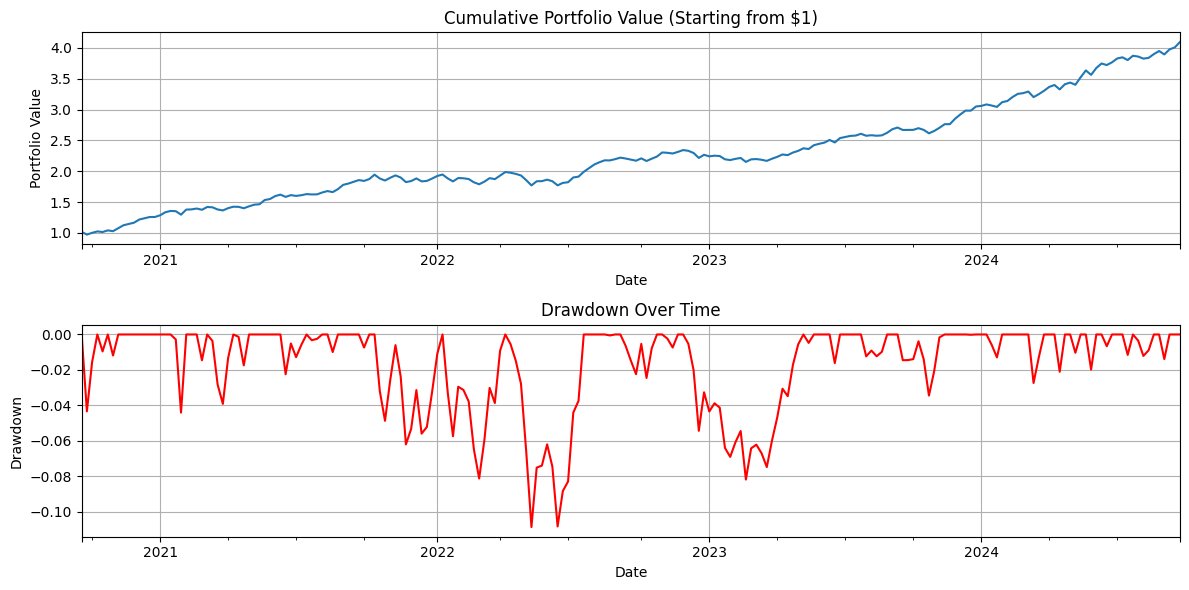

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load your dataset
# Load your dataset as an Excel file
file_path = '/content/total_df.csv'  # Replace with your actual file path
df = pd.read_csv(file_path, index_col='Date', parse_dates=True)


# Calculate weekly returns from daily data
def calculate_weekly_returns(df):
    return df.resample('W-FRI').last().pct_change().dropna()

# Function to calculate portfolio variance given weights and covariance matrix
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Function to calculate exponential weights for exponentially weighted covariance
def exponential_weights(n, alpha=0.94):
    weights = np.array([(1 - alpha) ** i for i in range(n)])
    return weights / np.sum(weights)

# Function to compute exponentially weighted covariance matrix
def exponentially_weighted_cov_matrix(returns, alpha=0.94):
    n = len(returns)
    weights = exponential_weights(n, alpha)
    mean_return = np.average(returns, axis=0, weights=weights)
    deviations = returns - mean_return
    weighted_cov = np.dot(deviations.T, weights[:, None] * deviations)
    return weighted_cov

# Function to calculate stock weightage (mean-variance optimization)
def get_stock_weightage(returns_window):
    cov_matrix = exponentially_weighted_cov_matrix(returns_window.values)
    num_stocks = len(returns_window.columns)
    initial_weights = np.array([1.0 / num_stocks] * num_stocks)
    bounds = tuple((0, 1) for _ in range(num_stocks))
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    # Optimize portfolio weights to minimize variance
    result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return {returns_window.columns[i]: result.x[i] for i in range(num_stocks)}

# Backtesting strategy
def backtest_strategy(df):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []

    for i in range(50, len(weekly_returns)):
        current_date = weekly_returns.index[i-1]
        next_week = weekly_returns.index[i]

        try:
            weightage = get_stock_weightage(weekly_returns.iloc[i-50:i])
            top_stocks = list(weightage.keys())
            weights = list(weightage.values())

            # Calculate portfolio return for the next week
            next_week_return = weekly_returns.loc[next_week][top_stocks].dot(weights)
            portfolio_returns.append(next_week_return)
            weightage_history.append((next_week, weightage))

        except ValueError:
            print(f"Skipping week {next_week} due to insufficient data")

    # Adjust to make sure the length of portfolio_returns and index match
    valid_index = weekly_returns.index[50:50+len(portfolio_returns)]

    return pd.Series(portfolio_returns, index=valid_index), weightage_history

# Calculate drawdown and max drawdown
def calculate_drawdown(cumulative_returns):
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    max_drawdown = drawdown.min()
    return drawdown, max_drawdown

# Calculate Sortino ratio
def sortino_ratio(returns, target=0, periods_per_year=52):
    downside_returns = returns[returns < target]
    downside_deviation = np.sqrt((downside_returns ** 2).mean()) * np.sqrt(periods_per_year)
    annualized_return = returns.mean() * periods_per_year
    return annualized_return / downside_deviation if downside_deviation != 0 else np.nan

# Calculate Calmar ratio
def calmar_ratio(annualized_return, max_drawdown):
    return annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

# Run the backtest
portfolio_returns, weightage_history = backtest_strategy(df)

# Calculate cumulative returns and performance metrics
cumulative_returns = (1 + portfolio_returns).cumprod()
total_return = cumulative_returns.iloc[-1]
profit_only_return = total_return - 1
annualized_return = (total_return ** (52/len(cumulative_returns)) - 1)
annualized_volatility = portfolio_returns.std() * np.sqrt(52)
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52)

# Calculate drawdown and additional metrics
drawdown, max_drawdown = calculate_drawdown(cumulative_returns)
calmar = calmar_ratio(annualized_return, max_drawdown)
sortino = sortino_ratio(portfolio_returns)

# Print backtest results
print("\nBacktest Results:")
print(f"Total Return (including initial capital): {total_return:.4f}")
print(f"This means for every $1 invested, you now have ${total_return:.2f}")
print(f"Profit-only Return: {profit_only_return:.4%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar:.2f}")

# Plot cumulative returns and drawdown
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
cumulative_returns.plot()
plt.title('Cumulative Portfolio Value (Starting from $1)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)

plt.subplot(2, 1, 2)
drawdown.plot(color='red')
plt.title('Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Example: Get the weights for a specific week
def get_weights_for_week(target_week, weightage_history):
    # Look for the target week in the weightage history
    for week, weightage in weightage_history:
        if week == target_week:
            print(f"\nStock weightage for week of {week.date()}:")
            for stock, weight in weightage.items():
                print(f"{stock}: {weight:.4f}")
            return weightage  # Return the weightage dictionary
    print(f"No weightage found for the week of {target_week.date()}")

# Select the target week you want to inspect
# Example: You can set this to any week from your backtest
target_week = pd.Timestamp('2023-08-04')  # Replace this with your desired week

# Call the function to get the weights for the specified week
get_weights_for_week(target_week, weightage_history)


Stock weightage for week of 2023-08-04:
JSWSTEEL: 0.0196
TATASTEEL: 0.0196
MARUTI: 0.0196
SBI: 0.0196
TATAMOTORS: 0.0196
TRENT: 0.0196
TITAN: 0.0196
ONGC: 0.0196
RELIANCE: 0.0196
M&M: 0.0196
KOTAK: 0.0196
ICICI: 0.0196
HDFC: 0.0196
DMART: 0.0196
EICHERMOT: 0.0196
BAJAJAUTO: 0.0196
BAJAJFIN: 0.0196
BAJAJ FINS: 0.0196
ADANIENT: 0.0196
ASIANPAINTS: 0.0196
AXIS: 0.0196
ADANIGREEN: 0.0196
NTPC: 0.0196
ABB: 0.0196
ADANIENT.1: 0.0196
BEL: 0.0196
BHARTIARTL: 0.0196
CIPLA: 0.0196
COALINDIA: 0.0196
DLF: 0.0196
DRREDDY: 0.0196
GODREJCP: 0.0196
HAL: 0.0196
HCLTECH: 0.0196
HINDUNILVR: 0.0196
HINDZINC: 0.0196
ITC: 0.0196
INDIGO: 0.0196
LTIM: 0.0196
LT: 0.0196
NESTLEIND: 0.0196
PIDILITIND: 0.0196
SIEMENS: 0.0196
SUNPHARMA: 0.0196
VBL: 0.0196
ULTRACEMCO: 0.0196
VEDL: 0.0196
WIPRO: 0.0196
INFY: 0.0196
TCS: 0.0196
powergrid: 0.0196


{'JSWSTEEL': 0.0196078431372549,
 'TATASTEEL': 0.0196078431372549,
 'MARUTI': 0.0196078431372549,
 'SBI': 0.0196078431372549,
 'TATAMOTORS': 0.0196078431372549,
 'TRENT': 0.0196078431372549,
 'TITAN': 0.0196078431372549,
 'ONGC': 0.0196078431372549,
 'RELIANCE': 0.0196078431372549,
 'M&M': 0.0196078431372549,
 'KOTAK': 0.0196078431372549,
 'ICICI': 0.0196078431372549,
 'HDFC': 0.0196078431372549,
 'DMART': 0.0196078431372549,
 'EICHERMOT': 0.0196078431372549,
 'BAJAJAUTO': 0.0196078431372549,
 'BAJAJFIN': 0.0196078431372549,
 'BAJAJ FINS': 0.0196078431372549,
 'ADANIENT': 0.0196078431372549,
 'ASIANPAINTS': 0.0196078431372549,
 'AXIS': 0.0196078431372549,
 'ADANIGREEN': 0.0196078431372549,
 'NTPC': 0.0196078431372549,
 'ABB': 0.0196078431372549,
 'ADANIENT.1': 0.0196078431372549,
 'BEL': 0.0196078431372549,
 'BHARTIARTL': 0.0196078431372549,
 'CIPLA': 0.0196078431372549,
 'COALINDIA': 0.0196078431372549,
 'DLF': 0.0196078431372549,
 'DRREDDY': 0.0196078431372549,
 'GODREJCP': 0.0196078

<ipython-input-25-bda8a533f575>:8: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(file_path, index_col='Date', parse_dates=True)



Backtest Results:
Total Return (including initial capital): 4.4282
This means for every $1 invested, you now have $4.43
Profit-only Return: 342.8231%
Annualized Return: 44.30%
Annualized Volatility: 17.98%
Sharpe Ratio: 2.14
Sortino Ratio: 2.21
Max Drawdown: -14.53%
Calmar Ratio: 3.05


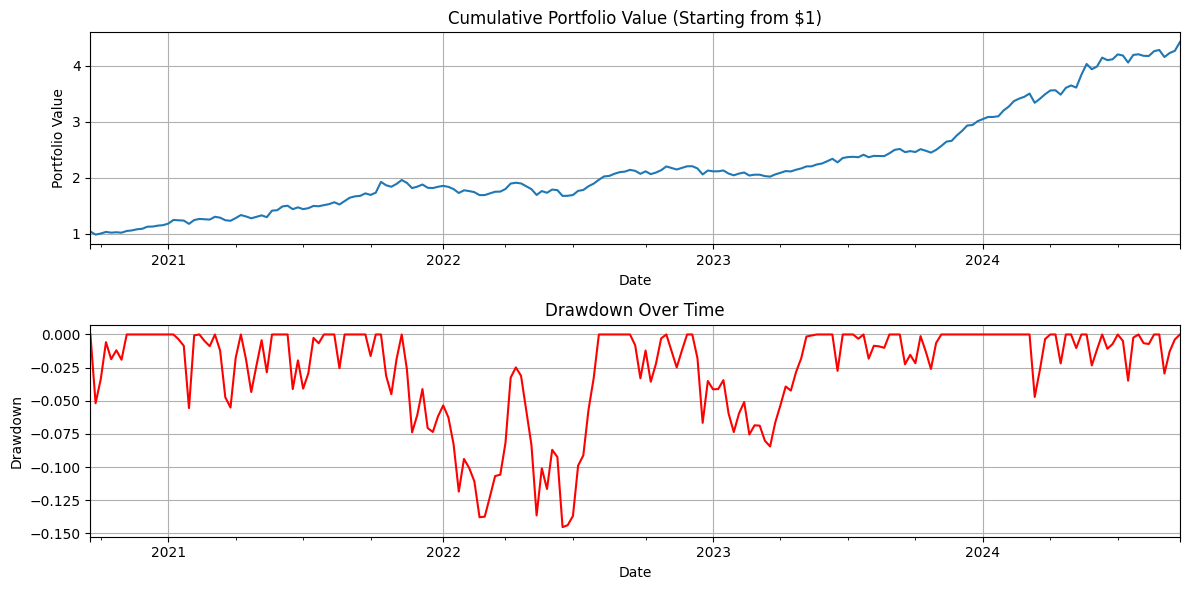


Stock weightage for the week of 2019-09-26:
TRENT: 0.0500
VEDL: 0.0500
BAJAJAUTO: 0.0500
ADANIGREEN: 0.0500
HAL: 0.0500
BEL: 0.0500
SIEMENS: 0.0500
M&M: 0.0500
ABB: 0.0500
HINDZINC: 0.0500
powergrid: 0.0500
INDIGO: 0.0500
NTPC: 0.0500
ADANIENT.1: 0.0500
BHARTIARTL: 0.0500
COALINDIA: 0.0500
VBL: 0.0500
ONGC: 0.0500
DLF: 0.0500
SUNPHARMA: 0.0500


In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load your dataset
file_path = '/content/total_df.csv'  # Replace with your actual file path
df = pd.read_csv(file_path, index_col='Date', parse_dates=True)

# Calculate weekly returns from daily data
def calculate_weekly_returns(df):
    return df.resample('W-FRI').last().pct_change().dropna()

# Function to calculate portfolio variance given weights and covariance matrix
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Function to calculate exponential weights for exponentially weighted covariance
def exponential_weights(n, alpha=0.94):
    weights = np.array([(1 - alpha) ** i for i in range(n)])
    return weights / np.sum(weights)

# Function to compute exponentially weighted covariance matrix
def exponentially_weighted_cov_matrix(returns, alpha=0.90):
    n = len(returns)
    weights = exponential_weights(n, alpha)
    mean_return = np.average(returns, axis=0, weights=weights)
    deviations = returns - mean_return
    weighted_cov = np.dot(deviations.T, weights[:, None] * deviations)
    return weighted_cov

# Function to calculate stock weightage (mean-variance optimization for top 20 stocks)
def get_stock_weightage(returns_window, top_stocks):
    returns_window = returns_window[top_stocks]  # Only consider top 20 stocks
    cov_matrix = exponentially_weighted_cov_matrix(returns_window.values)
    num_stocks = len(returns_window.columns)
    initial_weights = np.array([1.0 / num_stocks] * num_stocks)
    bounds = tuple((0, 1) for _ in range(num_stocks))
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    # Optimize portfolio weights to minimize variance
    result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return {returns_window.columns[i]: result.x[i] for i in range(num_stocks)}

# Backtesting strategy with stock selection (top 20 based on returns)
def backtest_strategy(df):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []

    for i in range(50, len(weekly_returns)):
        current_date = weekly_returns.index[i-1]
        next_week = weekly_returns.index[i]

        try:
            # Get the rolling window of the last 50 weeks of returns
            returns_window = weekly_returns.iloc[i-50:i]

            # Calculate the average returns over the rolling window for each stock
            average_returns = returns_window.mean()

            # Select the top 20 stocks with the highest average returns
            top_20_stocks = average_returns.nlargest(20).index

            # Perform mean-variance optimization on the top 20 stocks
            weightage = get_stock_weightage(returns_window, top_20_stocks)

            # Calculate portfolio return for the next week based on the selected stocks and their weights
            next_week_return = weekly_returns.loc[next_week][top_20_stocks].dot(list(weightage.values()))
            portfolio_returns.append(next_week_return)
            weightage_history.append((next_week, weightage))

        except ValueError:
            print(f"Skipping week {next_week} due to insufficient data")

    # Adjust to make sure the length of portfolio_returns and index match
    valid_index = weekly_returns.index[50:50+len(portfolio_returns)]

    return pd.Series(portfolio_returns, index=valid_index), weightage_history

# Calculate drawdown and max drawdown
def calculate_drawdown(cumulative_returns):
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    max_drawdown = drawdown.min()
    return drawdown, max_drawdown

# Calculate Sortino ratio
def sortino_ratio(returns, target=0, periods_per_year=52):
    downside_returns = returns[returns < target]
    downside_deviation = np.sqrt((downside_returns ** 2).mean()) * np.sqrt(periods_per_year)
    annualized_return = returns.mean() * periods_per_year
    return annualized_return / downside_deviation if downside_deviation != 0 else np.nan

# Calculate Calmar ratio
def calmar_ratio(annualized_return, max_drawdown):
    return annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

# Run the backtest
portfolio_returns, weightage_history = backtest_strategy(df)

# Calculate cumulative returns and performance metrics
cumulative_returns = (1 + portfolio_returns).cumprod()
total_return = cumulative_returns.iloc[-1]
profit_only_return = total_return - 1
annualized_return = (total_return ** (52/len(cumulative_returns)) - 1)
annualized_volatility = portfolio_returns.std() * np.sqrt(52)
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52)

# Calculate drawdown and additional metrics
drawdown, max_drawdown = calculate_drawdown(cumulative_returns)
calmar = calmar_ratio(annualized_return, max_drawdown)
sortino = sortino_ratio(portfolio_returns)

# Print backtest results
print("\nBacktest Results:")
print(f"Total Return (including initial capital): {total_return:.4f}")
print(f"This means for every $1 invested, you now have ${total_return:.2f}")
print(f"Profit-only Return: {profit_only_return:.4%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar:.2f}")

# Plot cumulative returns and drawdown
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
cumulative_returns.plot()
plt.title('Cumulative Portfolio Value (Starting from $1)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)

plt.subplot(2, 1, 2)
drawdown.plot(color='red')
plt.title('Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)

plt.tight_layout()
plt.show()

# Get weightage for the last date in the dataset (last 50 weeks)
last_date = df.index[-1238]
returns_window_last_50 = calculate_weekly_returns(df).iloc[-50:]

# Calculate the average returns over the last 50 weeks
average_returns_last_50 = returns_window_last_50.mean()

# Select the top 20 stocks based on the highest average returns
top_20_stocks_last_50 = average_returns_last_50.nlargest(20).index

# Get stock weightage for the last 50 weeks
try:
    weightage_last_date = get_stock_weightage(returns_window_last_50, top_20_stocks_last_50)
    print(f"\nStock weightage for the week of {last_date.date()}:")
    for stock, weight in weightage_last_date.items():
        print(f"{stock}: {weight:.4f}")
except ValueError as e:
    print(f"Error: {e}")


In [ ]:
cov_matrix = exponentially_weighted_cov_matrix(returns_window.values)
print(cov_matrix)


NameError: name 'returns_window' is not defined

<ipython-input-2-73c551bda81b>:8: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(file_path, index_col='Date', parse_dates=True)



Backtest Results (Without Transaction Costs):
Total Return (including initial capital): 4.4282
Profit-only Return: 342.8231%
Annualized Return: 44.30%
Annualized Volatility: 17.98%
Sharpe Ratio: 2.14
Sortino Ratio: 2.21
Max Drawdown: -14.53%
Calmar Ratio: 3.05

Backtest Results (With Transaction Costs):
Adjusted Total Return (including initial capital): 4.3242
Adjusted Profit-only Return: 332.4220%
Adjusted Annualized Return: 43.46%
Adjusted Max Drawdown: -15.76%
Adjusted Calmar Ratio: 2.76


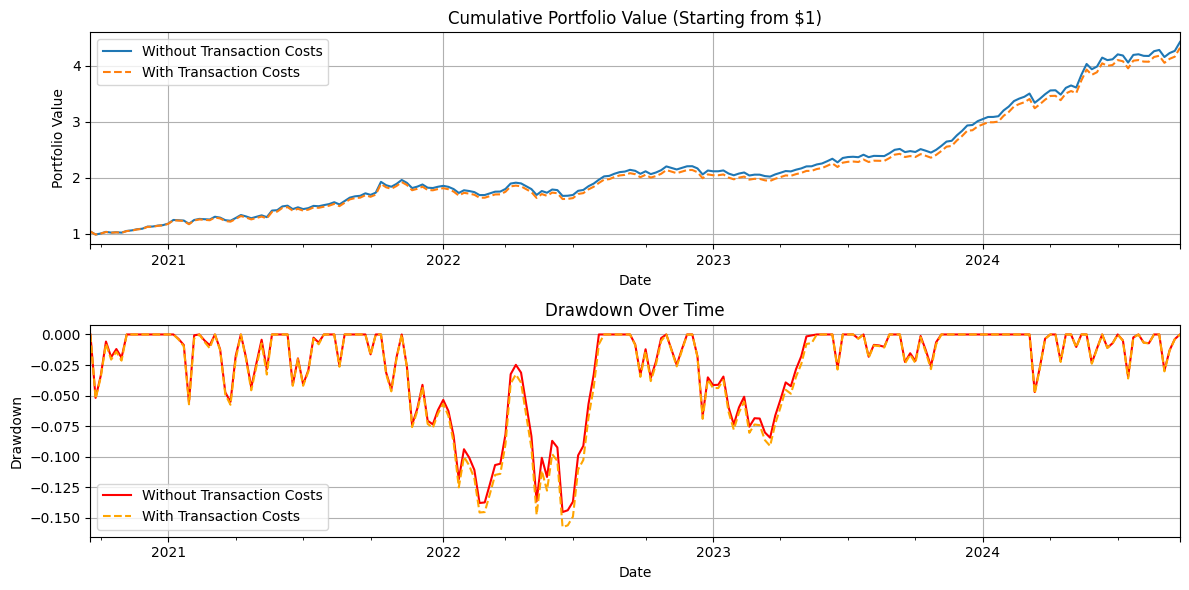


Stock weightage for the week of 2024-09-11:
TRENT: 0.0500
VEDL: 0.0500
BAJAJAUTO: 0.0500
ADANIGREEN: 0.0500
HAL: 0.0500
BEL: 0.0500
SIEMENS: 0.0500
M&M: 0.0500
ABB: 0.0500
HINDZINC: 0.0500
powergrid: 0.0500
INDIGO: 0.0500
NTPC: 0.0500
ADANIENT.1: 0.0500
BHARTIARTL: 0.0500
COALINDIA: 0.0500
VBL: 0.0500
ONGC: 0.0500
DLF: 0.0500
SUNPHARMA: 0.0500


In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load your dataset
file_path = '/content/total_df.csv'  # Replace with your actual file path
df = pd.read_csv(file_path, index_col='Date', parse_dates=True)

# Transaction cost rate
transaction_cost_rate = 0.001  # 0.1% transaction cost for buying or selling stocks

# Calculate weekly returns from daily data
def calculate_weekly_returns(df):
    return df.resample('W-FRI').last().pct_change().dropna()

# Function to calculate portfolio variance given weights and covariance matrix
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Function to calculate exponential weights for exponentially weighted covariance
def exponential_weights(n, alpha=0.94):
    weights = np.array([(1 - alpha) ** i for i in range(n)])
    return weights / np.sum(weights)

# Function to compute exponentially weighted covariance matrix
def exponentially_weighted_cov_matrix(returns, alpha=0.90):
    n = len(returns)
    weights = exponential_weights(n, alpha)
    mean_return = np.average(returns, axis=0, weights=weights)
    deviations = returns - mean_return
    weighted_cov = np.dot(deviations.T, weights[:, None] * deviations)
    return weighted_cov

# Function to calculate stock weightage (mean-variance optimization for top 20 stocks)
def get_stock_weightage(returns_window, top_stocks):
    returns_window = returns_window[top_stocks]  # Only consider top 20 stocks
    cov_matrix = exponentially_weighted_cov_matrix(returns_window.values)
    num_stocks = len(returns_window.columns)
    initial_weights = np.array([1.0 / num_stocks] * num_stocks)
    bounds = tuple((0, 1) for _ in range(num_stocks))
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    # Optimize portfolio weights to minimize variance
    result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return {returns_window.columns[i]: result.x[i] for i in range(num_stocks)}

# Backtesting strategy with stock selection (top 20 based on returns) and transaction costs
def backtest_strategy(df):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []
    transaction_costs = []

    for i in range(50, len(weekly_returns)):
        current_date = weekly_returns.index[i-1]
        next_week = weekly_returns.index[i]

        try:
            # Get the rolling window of the last 50 weeks of returns
            returns_window = weekly_returns.iloc[i-50:i]

            # Calculate the average returns over the rolling window for each stock
            average_returns = returns_window.mean()

            # Select the top 20 stocks with the highest average returns
            top_20_stocks = average_returns.nlargest(20).index

            # Perform mean-variance optimization on the top 20 stocks
            weightage = get_stock_weightage(returns_window, top_20_stocks)

            # Calculate portfolio return for the next week based on the selected stocks and their weights
            next_week_return = weekly_returns.loc[next_week][top_20_stocks].dot(list(weightage.values()))
            portfolio_returns.append(next_week_return)

            # Transaction cost calculation
            if weightage_history:
                previous_weights = weightage_history[-1][1]
                # Calculate the weight changes between the current and previous week
                weight_changes = {stock: abs(weightage.get(stock, 0) - previous_weights.get(stock, 0))
                                  for stock in set(weightage) | set(previous_weights)}
                # Calculate transaction cost
                transaction_cost = transaction_cost_rate * sum(weight_changes.values())
            else:
                transaction_cost = 0

            transaction_costs.append(transaction_cost)
            weightage_history.append((next_week, weightage))

        except ValueError:
            print(f"Skipping week {next_week} due to insufficient data")

    # Adjust to make sure the length of portfolio_returns and index match
    valid_index = weekly_returns.index[50:50+len(portfolio_returns)]

    return pd.Series(portfolio_returns, index=valid_index), weightage_history, pd.Series(transaction_costs, index=valid_index)

# Calculate drawdown and max drawdown
def calculate_drawdown(cumulative_returns):
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    max_drawdown = drawdown.min()
    return drawdown, max_drawdown

# Calculate Sortino ratio
def sortino_ratio(returns, target=0, periods_per_year=52):
    downside_returns = returns[returns < target]
    downside_deviation = np.sqrt((downside_returns ** 2).mean()) * np.sqrt(periods_per_year)
    annualized_return = returns.mean() * periods_per_year
    return annualized_return / downside_deviation if downside_deviation != 0 else np.nan

# Calculate Calmar ratio
def calmar_ratio(annualized_return, max_drawdown):
    return annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

# Run the backtest
portfolio_returns, weightage_history, transaction_costs = backtest_strategy(df)

# Calculate cumulative returns and performance metrics
cumulative_returns = (1 + portfolio_returns).cumprod()
adjusted_cumulative_returns = cumulative_returns - transaction_costs.cumsum()

total_return = cumulative_returns.iloc[-1]
adjusted_total_return = adjusted_cumulative_returns.iloc[-1]

profit_only_return = total_return - 1
adjusted_profit_only_return = adjusted_total_return - 1

annualized_return = (total_return ** (52/len(cumulative_returns)) - 1)
adjusted_annualized_return = (adjusted_total_return ** (52/len(adjusted_cumulative_returns)) - 1)

annualized_volatility = portfolio_returns.std() * np.sqrt(52)
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52)

# Calculate drawdown and additional metrics
drawdown, max_drawdown = calculate_drawdown(cumulative_returns)
adjusted_drawdown, adjusted_max_drawdown = calculate_drawdown(adjusted_cumulative_returns)

calmar = calmar_ratio(annualized_return, max_drawdown)
adjusted_calmar = calmar_ratio(adjusted_annualized_return, adjusted_max_drawdown)

sortino = sortino_ratio(portfolio_returns)

# Print backtest results
print("\nBacktest Results (Without Transaction Costs):")
print(f"Total Return (including initial capital): {total_return:.4f}")
print(f"Profit-only Return: {profit_only_return:.4%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar:.2f}")

print("\nBacktest Results (With Transaction Costs):")
print(f"Adjusted Total Return (including initial capital): {adjusted_total_return:.4f}")
print(f"Adjusted Profit-only Return: {adjusted_profit_only_return:.4%}")
print(f"Adjusted Annualized Return: {adjusted_annualized_return:.2%}")
print(f"Adjusted Max Drawdown: {adjusted_max_drawdown:.2%}")
print(f"Adjusted Calmar Ratio: {adjusted_calmar:.2f}")

# Plot cumulative returns and drawdown
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
cumulative_returns.plot(label='Without Transaction Costs')
adjusted_cumulative_returns.plot(label='With Transaction Costs', linestyle='--')
plt.title('Cumulative Portfolio Value (Starting from $1)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
drawdown.plot(label='Without Transaction Costs', color='red')
adjusted_drawdown.plot(label='With Transaction Costs', linestyle='--', color='orange')
plt.title('Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Get weightage for the last date in the dataset (last 50 weeks)
last_date = df.index[-12]
returns_window_last_50 = calculate_weekly_returns(df).iloc[-50:]

# Calculate the average returns over the last 50 weeks
average_returns_last_50 = returns_window_last_50.mean()

# Select the top 20 stocks based on the highest average returns
top_20_stocks_last_50 = average_returns_last_50.nlargest(20).index

# Get stock weightage for the last 50 weeks
try:
    weightage_last_date = get_stock_weightage(returns_window_last_50, top_20_stocks_last_50)
    print(f"\nStock weightage for the week of {last_date.date()}:")
    for stock, weight in weightage_last_date.items():
        print(f"{stock}: {weight:.4f}")
except ValueError as e:
    print(f"Error: {e}")
